# Mount Drive

This section is only if you are working in Google Colab as you will need to mount your Google Drive to the notebook for access to the dataset stored in your Google Drive

In [2]:
# Mount data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [4]:
# package to split dataset into train, validation and test
!pip install split-folders

# use Multi-Task Cascaded CNN (MTCNN) for face detection
# eg find and extract faces from photos
# state of art deep learnnig model for face detection in 2016
# install the mtcnn package
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 5.3 MB/s 


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import splitfolders

from PIL import Image
from numpy import asarray
# from scipy.spatial.distance import cosine
from mtcnn.mtcnn import MTCNN
# from keras_vggface.vggface import VGGFace
# from keras_vggface.utils import preprocess_input
%matplotlib inline

## Google Colab to change directory to current working directory

This section is only if you are working in Google Colab to change to your current working directory so you can access the dataset.

In [8]:
cd drive/MyDrive/Colab\ Notebooks/GA-Capstone/

/content/drive/MyDrive/Colab Notebooks/GA-Capstone


In [9]:
capstone_dir = os.getcwd()

In [10]:
capstone_dir

'/content/drive/MyDrive/Colab Notebooks/GA-Capstone'

# Arrange Files into Train, Valid and Test Folders

The split-folders package is used to split the image dataset into the train, validation and test folder by specifying the ratio. In this case, the ratio is split into 70% for training, 20% for validation and 10% for testing.

## Split the dataset into train, valid and test folders using split-folders package

The code below is only valid for Google Colab

In [ ]:
input_folder = 'dataset/soccer-dataset'
output_folder = 'dataset/train-valid-test'

If you are using your own local machine, please use the relative path to specify for the input and output folders respectively. In the case where you clone from my github repository. Please use the below code to specify the folders path. From here onwards, please modify the path accordingly to get to the correct directory for accessing the data. PLEASE NOTE that the data path specified in this notebook is only valid for working in Google Colab. YOU WILL. NEED TO EDIT THE PATH ACCORDINGLY to where your dataset or your folders are.

In [ ]:
input_folder = '../dataset/soccer-dataset'
output_folder = '../dataset/train-valid-test'

As the dataset used in this particular project is self-sourced via Google. Hence, there are only 20 images each for 100 soccer players. The Code below is to check if each folder has 20 images. Then, split-folders package is used to split them into their respective train, validation and test folder.

In [ ]:
for filename in os.listdir(input_folder):
  if len(os.listdir(input_folder + '/' + filename)) != 20:
    print(filename)

In [ ]:
# takes about 11min to copy all 2000 images
# 70% to train, 20% to valid, 10% to test
splitfolders.ratio(input_folder, output=output_folder,
                   seed=42, ratio=(.7, .2, .1))

Copying files: 2000 files [00:18, 108.91 files/s]


## Check all folders have the correct number of images

In [ ]:
for filename in os.listdir(output_folder + '/train'):
  if len(os.listdir(output_folder + '/train/' + filename)) != 14:
    print(filename)

In [ ]:
for filename in os.listdir(output_folder + '/val'):
  if len(os.listdir(output_folder + '/val/' + filename)) != 4:
    print(filename)

In [ ]:
for filename in os.listdir(output_folder + '/test'):
  if len(os.listdir(output_folder + '/test/' + filename)) != 2:
    print(filename)

# Image Augmentation

Image augmentation is done here to expand the size of a training dataset by creating modified versions of images in the database. This is used to expand the training dataset in order to improve the performance and ability of the model to generalize. This step is done after splitting into the respective folders to avoid any data leakage from the test or validation set to the training dataset. An image augmentation example is shown below that creates 10 version from a single image we have in the dataset and we can see that if the augmented images are splitted into the 3 different folders, then it will result in data leakage. 

In [1]:
# plot images with rows of 10
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 5, figsize=(16, 8))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
# ImageDataGenerator helps to augment our image
# rotation between 0-10deg clock/anti-clock
# width/height shift between -0.1 and 0.1
gen_img = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=10, zoom_range=0.2, 
          channel_shift_range=10., horizontal_flip=True)

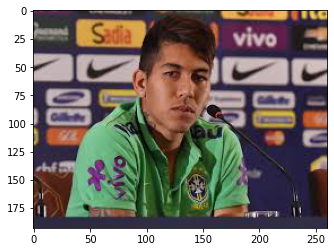

In [18]:
# os.listdir() gets the list of files in the dir/folder
chosen_image = random.choice(os.listdir('dataset/soccer-dataset/Roberto_Firmino/'))
image_path = 'dataset/soccer-dataset/Roberto_Firmino/' + chosen_image
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

In [19]:
# generate batches of augmented images from original image
# flow() takes in numpy data and generate batches of augmented data, takes in np array of rank 4 -> 4D
# previously need expand dims
aug_iter = gen_img.flow(image, batch_size=1)

# get 10 samples of augmented images
# unsigned int as we know pixels range from 0 to 255, always positive
# next() returns the next item in iterator
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

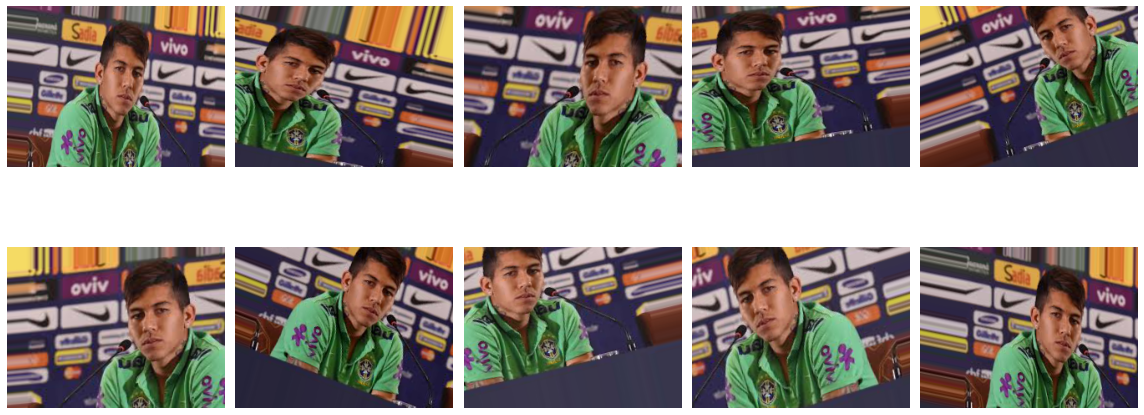

In [20]:
plotImages(aug_images)

## Function to Loop through train, valid and test folders for image augmentation

In [ ]:
def image_augmentation(img_path, dataset_name, num_images):
  full_path = os.path.join(img_path, dataset_name)
  for player_name in os.listdir(full_path):
    player_folder = os.path.join(full_path, player_name)
    for image_name in os.listdir(player_folder):
      img_path = os.path.join(player_folder, image_name)
      create_image(img_path, player_folder, player_name, num_images)

In [ ]:
def create_image(image_path, folder_to_save, player_name, num_images):
  
  # expand dims to rank 4 to be inputted to ImageDataGerenator
  image = np.expand_dims(plt.imread(image_path),0)

  # ImageDataGenerator helps to augment our image
  # rotation between 0-10deg clock/anti-clock
  # width/height shift between -0.1 and 0.1
  gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.2, 
      channel_shift_range=10., horizontal_flip=True)
  
  # return iterator
  aug_img = gen.flow(image, batch_size=1, save_prefix=player_name, save_to_dir=folder_to_save, save_format='jpg')
  
  # loop through the number of times to get new augmented image
  for _ in range(num_images):
    aug_img.next()

## Create new images using data augmentation for train, valid and test set

Each of the images in the 3 folders is augmented 10 times to expand the dataset to improve the performance and ability of the model to generalize as stated in the beginnging of this section.

In [ ]:
%%time
image_augmentation(output_folder, 'train', 10)

CPU times: user 3min 7s, sys: 4.97 s, total: 3min 12s
Wall time: 4min 23s


In [ ]:
%%time
image_augmentation(output_folder, 'val', 10)

CPU times: user 55.1 s, sys: 1.82 s, total: 56.9 s
Wall time: 1min 21s


In [ ]:
%%time
image_augmentation(output_folder, 'test', 10)

CPU times: user 28.1 s, sys: 790 ms, total: 28.9 s
Wall time: 39.4 s


# Extract Face from dataset for training purpose

## Functions to extract faces from iamge dataset and save to a new folder for training purpose

In [ ]:
# extract a single face from a given photograph
def extract_face(filename, dst_path, dataset_name, player_name, image_name, required_size=(224, 224)):
  # load image from file
  pixels = plt.imread(filename)
  # create the detector, using default weights
  detector = MTCNN()
  # detect faces in the image
  results = detector.detect_faces(pixels)

  ## try to catch if image do not detect any face
  try:
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
      # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    # face_array = asarray(image)
    # img = extract_face(img_path, required_size=(224, 224))
    # # face_array = np.array(img)
    # plt.imshow(face_array, cmap='gray')
    # break
    save_to_folder(dst_path, dataset_name, player_name, image_name, image)

  except IndexError:
    pass

In [ ]:
def save_to_folder(path_to_save, dataset_name, player_name, img_name, image):
    if os.path.isdir(os.path.join(path_to_save, dataset_name, player_name)) is False:
      os.mkdir(os.path.join(path_to_save, dataset_name, player_name))
    image.save(os.path.join(path_to_save, dataset_name, player_name, f'{img_name}'))

In [ ]:
def save_face_img(src_path, dst_path, dataset_name):
  full_path = os.path.join(src_path, dataset_name)
  for player_name in os.listdir(full_path):
    player_folder = os.path.join(full_path, player_name)
    for image_name in os.listdir(player_folder):
      img_path = os.path.join(player_folder, image_name)
      extract_face(img_path, dst_path, dataset_name, player_name, image_name)

## Specify the output folder for the cropped dataset to be saved to for training purpose

In [ ]:
path_to_save = 'dataset/processed-dataset/'
if os.path.isdir(path_to_save) is False:
  os.mkdir(path_to_save)
  os.mkdir(os.path.join(path_to_save, 'train'))
  os.mkdir(os.path.join(path_to_save, 'val'))
  os.mkdir(os.path.join(path_to_save, 'test'))

In [ ]:
%%time
# takes 5hr 42min
# 15229
save_face_img(output_folder, path_to_save, 'train')

CPU times: user 4h 59min 51s, sys: 6min 58s, total: 5h 6min 49s
Wall time: 5h 42min 24s


In [ ]:
%%time
# 1hr 28min
# 4371
save_face_img(output_folder, path_to_save, 'val')

CPU times: user 1h 28min 58s, sys: 2min 21s, total: 1h 31min 19s
Wall time: 1h 41min 24s


In [ ]:
%%time
# takes 47min
# 2100++
save_face_img(output_folder, path_to_save, 'test')

CPU times: user 42min 40s, sys: 53.1 s, total: 43min 33s
Wall time: 47min 51s
